# Original Dense Diffusion

In [1]:
import torch
import os
import numpy as np
import diffusers
import random
import pickle

from PIL import Image
from tqdm.auto import tqdm
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers.pipelines import DiffusionPipeline
from diffusers import DDIMScheduler

import transformers
from transformers import CLIPTextModel, CLIPTokenizer
import torch.nn.functional as F
from torchvision import transforms

# token = ## Put your access token here ##
device= "cuda"

In [2]:
pipe = diffusers.StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        safety_checker=None,
        variant="fp16",
        cache_dir='./models/diffusers/').to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps
sp_sz = pipe.unet.sample_size
bsz = 1

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [19]:
1/0

ZeroDivisionError: division by zero

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
def mod_forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):

    residual = hidden_states

    if self.spatial_norm is not None:
        hidden_states = self.spatial_norm(hidden_states, temb)

    input_ndim = hidden_states.ndim

    if input_ndim == 4:
        batch_size, channel, height, width = hidden_states.shape
        hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

    batch_size, sequence_length, _ = (hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape)
    attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

    if self.group_norm is not None:
        hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

    query = self.to_q(hidden_states)

    sa_ = True if encoder_hidden_states is None else False
    encoder_hidden_states = text_cond if encoder_hidden_states is not None else hidden_states
    if self.norm_cross:
        encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

    key = self.to_k(encoder_hidden_states)
    value = self.to_v(encoder_hidden_states)

    query = self.head_to_batch_dim(query)
    key = self.head_to_batch_dim(key)
    value = self.head_to_batch_dim(value)
    
    #################################################
    global COUNT
    
    if COUNT/32 < 50*reg_part:
        
        dtype = query.dtype
        if self.upcast_attention:
            query = query.float()
            key = key.float()
            
        sim = torch.baddbmm(torch.empty(query.shape[0], query.shape[1], key.shape[1], 
                                        dtype=query.dtype, device=query.device),
                            query, key.transpose(-1, -2), beta=0, alpha=self.scale)
        
        treg = torch.pow(timesteps[COUNT//32]/1000, 5)
        
        ## reg at self-attn
        if sa_:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)  
            mask = sreg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)
            
            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*sreg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*sreg*treg*(sim[int(sim.size(0)/2):]-min_value)
            
            
        ## reg at cross-attn
        else:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)  
            mask = creg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)
            
            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*creg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*creg*treg*(sim[int(sim.size(0)/2):]-min_value)
            
        attention_probs = sim.softmax(dim=-1)
        attention_probs = attention_probs.to(dtype)
            
    else:
        attention_probs = self.get_attention_scores(query, key, attention_mask)
           
    COUNT += 1
    #################################################        

    hidden_states = torch.bmm(attention_probs, value)
    hidden_states = self.batch_to_head_dim(hidden_states)

    # linear proj
    hidden_states = self.to_out[0](hidden_states)
    # dropout
    hidden_states = self.to_out[1](hidden_states)

    if input_ndim == 4:
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

    if self.residual_connection:
        hidden_states = hidden_states + residual

    hidden_states = hidden_states / self.rescale_output_factor

    return hidden_states

In [14]:
for _module in pipe.unet.modules():
    if _module.__class__.__name__ == "Attention":
        _module.__class__.__call__ = mod_forward

In [15]:
with open('./dataset/valset.pkl', 'rb') as f:
    dataset = pickle.load(f)
layout_img_root = './dataset/valset_layout/'

# with open('./dataset/testset.pkl', 'rb') as f:
#     dataset = pickle.load(f)
# layout_img_root = './dataset/testset_layout/'

A painting of a couple holding a yellow umbrella in a street on a rainy night. The woman is wearing a white dress and the man is wearing a blue suit.
a street on a rainy night
the man is wearing a blue suit
a yellow umbrella
the woman is wearing a white dress


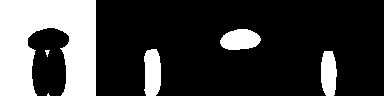

In [16]:
idx = 5
layout_img_path = layout_img_root+str(idx)+'.png'
prompts = [dataset[idx]['textual_condition']] + dataset[idx]['segment_descriptions']

############
text_input = pipe.tokenizer(prompts, padding="max_length", return_length=True, return_overflowing_tokens=False, 
                            max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
cond_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

uncond_input = pipe.tokenizer([""]*bsz, padding="max_length", max_length=pipe.tokenizer.model_max_length,
                              truncation=True, return_tensors="pt")
uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

for i in range(1,len(prompts)):
    wlen = text_input['length'][i] - 2
    widx = text_input['input_ids'][i][1:1+wlen]
    for j in range(77):
        if (text_input['input_ids'][0][j:j+wlen] == widx).sum() == wlen:
            break

############
layout_img_ = np.asarray(Image.open(layout_img_path).resize([sp_sz*8,sp_sz*8]))[:,:,:3]
unique, counts = np.unique(np.reshape(layout_img_,(-1,3)), axis=0, return_counts=True)
sorted_idx = np.argsort(-counts)

layouts_ = []

for i in range(len(prompts)-1):
    if (unique[sorted_idx[i]] == [0, 0, 0]).all() or (unique[sorted_idx[i]] == [255, 255, 255]).all():
        layouts_ = [((layout_img_ == unique[sorted_idx[i]]).sum(-1)==3).astype(np.uint8)] + layouts_
    else:
        layouts_.append(((layout_img_ == unique[sorted_idx[i]]).sum(-1)==3).astype(np.uint8))
        
layouts = [torch.FloatTensor(l).unsqueeze(0).unsqueeze(0).cuda() for l in layouts_]
layouts = F.interpolate(torch.cat(layouts),(sp_sz,sp_sz),mode='nearest')

############
print('\n'.join(prompts))
Image.fromarray(np.concatenate([255*_.squeeze().cpu().numpy() for _ in layouts], 1).astype(np.uint8))

In [17]:
###########################
###### prep for sreg ###### 
###########################
sreg_maps = {}
reg_sizes = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layouts_s = F.interpolate(layouts,(res, res),mode='nearest')
    layouts_s = (layouts_s.view(layouts_s.size(0),1,-1)*layouts_s.view(layouts_s.size(0),-1,1)).sum(0).unsqueeze(0).repeat(bsz,1,1)
    reg_sizes[np.power(res, 2)] = 1-1.*layouts_s.sum(-1, keepdim=True)/(np.power(res, 2))
    sreg_maps[np.power(res, 2)] = layouts_s
    
    
###########################
###### prep for creg ######
###########################
pww_maps = torch.zeros(1, 77, sp_sz, sp_sz).to(device)
for i in range(1,len(prompts)):
    wlen = text_input['length'][i] - 2
    widx = text_input['input_ids'][i][1:1+wlen]
    for j in range(77):
        if (text_input['input_ids'][0][j:j+wlen] == widx).sum() == wlen:
            pww_maps[:,j:j+wlen,:,:] = layouts[i-1:i]
            cond_embeddings[0][j:j+wlen] = cond_embeddings[i][1:1+wlen]
            print(prompts[i], i, '-th segment is handled.')
            break
            
creg_maps = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layout_c = F.interpolate(pww_maps,(res,res),mode='nearest').view(1,77,-1).permute(0,2,1).repeat(bsz,1,1)
    creg_maps[np.power(res, 2)] = layout_c

    
###########################    
#### prep for text_emb ####
###########################
text_cond = torch.cat([uncond_embeddings, cond_embeddings[:1].repeat(bsz,1,1)])

a street on a rainy night 1 -th segment is handled.
the man is wearing a blue suit 2 -th segment is handled.
a yellow umbrella 3 -th segment is handled.
the woman is wearing a white dress 4 -th segment is handled.


In [26]:
reg_part = .3
sreg = .3
creg = 1.

COUNT = 0

with torch.no_grad():
#     latents = torch.randn(bsz,1,sp_sz,sp_sz).to(device)
    latents = torch.randn(bsz,4,sp_sz,sp_sz, generator=torch.Generator().manual_seed(1)).to(device) 
    with torch.autocast(device_type='cuda'):
        image = pipe(prompts[:1]*bsz, latents=latents).images

  0%|          | 0/4 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.53 GiB (GPU 0; 15.78 GiB total capacity; 12.40 GiB already allocated; 917.69 MiB free; 13.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

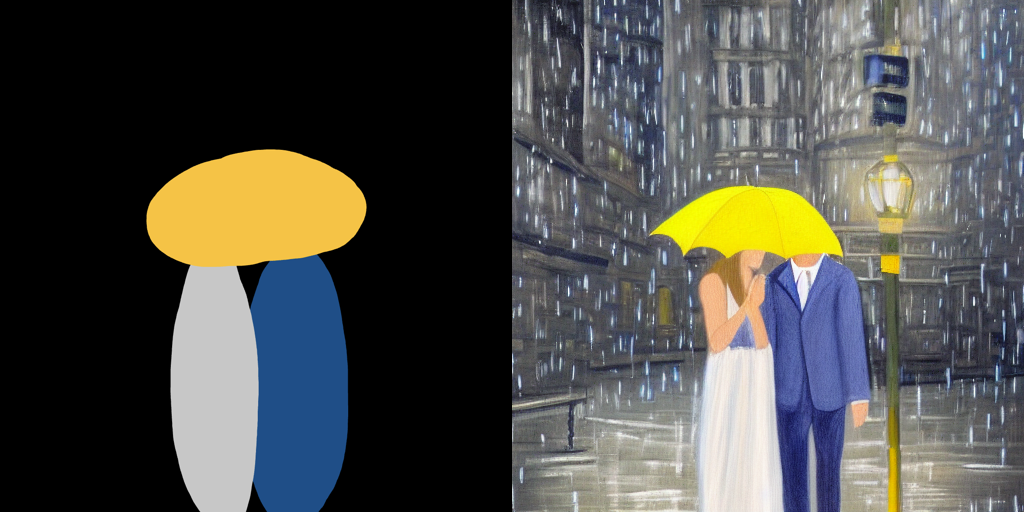

In [9]:
Image.fromarray(np.concatenate([layout_img_.astype(np.uint8)]+[np.asarray(image[i]) for i in range(len(image))], 1))

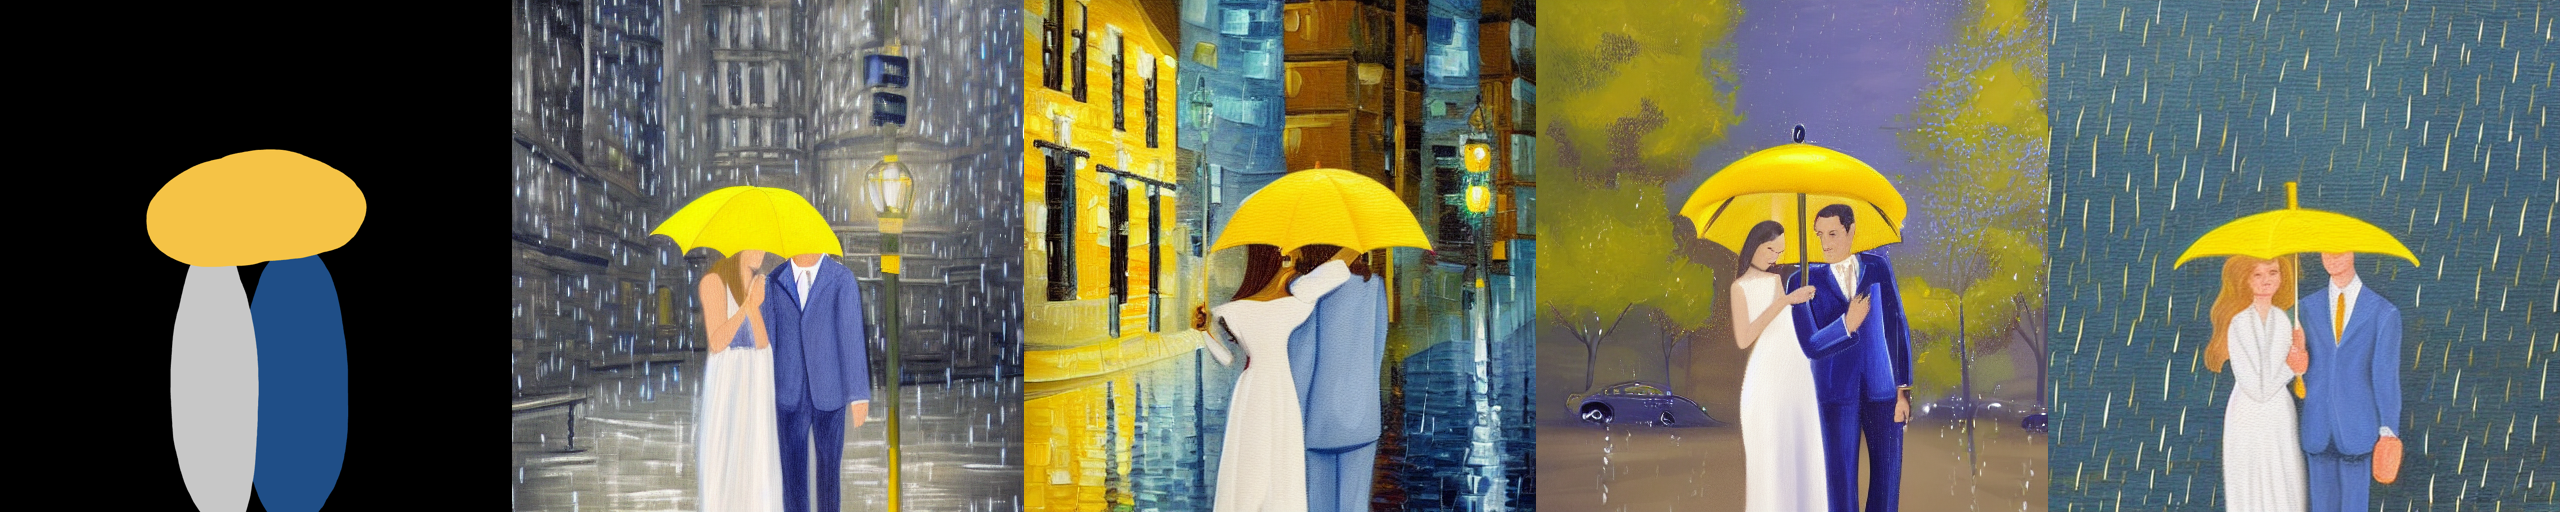

In [9]:
Image.fromarray(np.concatenate([layout_img_.astype(np.uint8)]+[np.asarray(image[i]) for i in range(len(image))], 1))

# LCM version

In [1]:
!nvidia-smi

Wed Dec 13 12:57:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [1]:
import os
import random
import pickle
import argparse
import pdb
import datetime
import hashlib

import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torchvision import transforms
import diffusers
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers.pipelines import DiffusionPipeline
from diffusers import DDIMScheduler, LCMScheduler
import transformers
from transformers import CLIPTextModel, CLIPTokenizer

In [2]:
command = "--model LCM --batch_size 1 -s 4 --reg_part 0.3 --idx 1 ".split()

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='LCM', choices=['LCM', 'SD'])
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--idx', type=int, default=[1], nargs="*",
                    help='dense diffusion dataset image mask & caption index')
parser.add_argument('-s', '--num_inference_steps', type=int, default=50)
parser.add_argument('--reg_part', type=float, default=.3)
parser.add_argument('--sreg', type=float, default=.3)
parser.add_argument('--creg', type=float, default=1)
parser.add_argument('--pow_time', type=float, default=5)
parser.add_argument('-w', '--wo_modulation', action=argparse.BooleanOptionalAction, default=False,
                    help='when True, run inference without dense diffusion attention manipulation')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--debug', type=str)
args = parser.parse_args(command)

In [6]:
args

Namespace(model='LCM', batch_size=1, idx=[1], num_inference_steps=4, reg_part=0.3, sreg=0.3, creg=1, pow_time=5, wo_modulation=False, seed=1, debug=None)

In [7]:
## Set hyperparameters
device= "cuda"
num_inference_steps = args.num_inference_steps 
reg_part = args.reg_part if not args.wo_modulation else 0
sreg = args.sreg
creg = args.creg


## Load Model
if args.model == 'LCM':
    pipe = DiffusionPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")
    pipe.to(device=device, dtype=torch.float16)
    num_inference_steps = num_inference_steps
    lcm_origin_steps = 50
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler.set_timesteps(num_inference_steps=num_inference_steps,
                                 original_inference_steps=lcm_origin_steps,
                                 device=device)
else:
    pipe = diffusers.StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        safety_checker=None,
        variant="fp16",
        cache_dir='./models/diffusers/'
    ).to(device)
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler.set_timesteps(num_inference_steps)


## Set attn modulation variables
num_attn_layers = 32
timesteps = pipe.scheduler.timesteps
sp_sz = pipe.unet.sample_size
bsz = args.batch_size
idx = args.idx

mod_counts = []

print("=== Experiment Settings ===")
print("- Model:", args.model, "/ N inference steps:", num_inference_steps, "/ Batch size:", bsz)
print("- Regulation part:", reg_part, "/ Self attention regulation:", sreg, "/ Cross attention regulation:", creg, "/ Time regulation:", args.pow_time)
print("Chosen timesteps:", timesteps)


## attention modulation function
def mod_forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):
    global COUNT, treg, sret, creg, sreg_maps, creg_maps, reg_sizes, text_cond, step_store, attn_stores
    STEP = COUNT // 32
    if COUNT % 32 == 0 and STEP > 0:
        attn_stores.append(step_store)
        step_store = {"down_cross": [], "mid_cross": [], "up_cross": [],
                      "down_self": [],  "mid_self": [],  "up_self": []}

    residual = hidden_states 

    if self.spatial_norm is not None:
        hidden_states = self.spatial_norm(hidden_states, temb)

    input_ndim = hidden_states.ndim

    if input_ndim == 4:
        batch_size, channel, height, width = hidden_states.shape
        hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

    batch_size, sequence_length, _ = (hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape)
    attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

    if self.group_norm is not None:
        hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

    query = self.to_q(hidden_states)

    sa_ = True if encoder_hidden_states is None else False
    encoder_hidden_states = text_cond if encoder_hidden_states is not None else hidden_states
    if self.norm_cross:
        encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

    key = self.to_k(encoder_hidden_states)
    value = self.to_v(encoder_hidden_states)

    query = self.head_to_batch_dim(query)
    key = self.head_to_batch_dim(key)
    value = self.head_to_batch_dim(value)

    if sa_ == False and args.model == 'LCM':
        key =  key[key.size(0)//2:,  ...]
        value = value[value.size(0)//2:,  ...]

    # modulate attention with dense diffusion
    if (COUNT/num_attn_layers < num_inference_steps*reg_part):
        mod_counts.append(COUNT)
        dtype = query.dtype
        if self.upcast_attention:
            query = query.float()
            key = key.float()

        sim = torch.baddbmm(torch.empty(query.shape[0], query.shape[1], key.shape[1], 
                                        dtype=query.dtype, device=query.device),
                            query, key.transpose(-1, -2), beta=0, alpha=self.scale)
        treg = torch.pow(timesteps[COUNT//num_attn_layers]/1000, args.pow_time)
        reg_map = sreg_maps if sa_ else creg_maps
        w_reg = sreg if sa_ else creg

        # manipulate attention
        batch_idx = int(sim.size(0)/2) if args.model != 'LCM' else 0 # why do we have to apply below operations for latter half of sim???
        min_value = sim[batch_idx:].min(-1)[0].unsqueeze(-1)
        max_value = sim[batch_idx:].max(-1)[0].unsqueeze(-1)  
        mask = reg_map[sim.size(1)].repeat(self.heads,1,1)
        size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)

        sim[batch_idx:] += (mask>0)*size_reg*w_reg*treg*(max_value-sim[batch_idx:])
        sim[batch_idx:] -= ~(mask>0)*size_reg*w_reg*treg*(sim[batch_idx:]-min_value)

        attention_probs = sim.softmax(dim=-1)
        attention_probs = attention_probs.to(dtype)
    else: # get original attention
        attention_probs = self.get_attention_scores(query, key, attention_mask)

    COUNT += 1
    if attention_probs.shape[1] <= 32 ** 2: # save attention in each place(up, down, mid) when attention shape is small
        step_store[f"{self.place_in_unet.lower()}_{'self' if sa_ else 'cross'}"].append(attention_probs)

    #################################################        
    hidden_states = torch.bmm(attention_probs, value)
    hidden_states = self.batch_to_head_dim(hidden_states)

    # linear proj
    hidden_states = self.to_out[0](hidden_states)
    # dropout
    hidden_states = self.to_out[1](hidden_states)

    if input_ndim == 4:
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

    if self.residual_connection:
        hidden_states = hidden_states + residual

    hidden_states = hidden_states / self.rescale_output_factor

    return hidden_states


## change call function of attn layers in Unet 
for _module in pipe.unet.modules():
    n = _module.__class__.__name__
    if 'CrossAttn' in n:
        for place in ['Up', 'Down', 'Mid']:
            if place in n:
                curr_place = place

    if n == "Attention":
        _module.__class__.__call__ = mod_forward
        _module.place_in_unet = curr_place


## Load naver-ai/DenseDiffusion dataset
with open('./dataset/valset.pkl', 'rb') as f:
    dataset = pickle.load(f)
layout_img_root = './dataset/valset_layout/'


## Main function which generates modulated image
def generate_index_img(idx):
    global COUNT, treg, sret, creg, sreg_maps, creg_maps, reg_sizes, text_cond, step_store, attn_stores

    layout_img_path = layout_img_root+str(idx)+'.png'
    prompts = [dataset[idx]['textual_condition']] + dataset[idx]['segment_descriptions']
    prompts_idx[idx] = prompts[0]
    ## prepare text condition embeddings
    ############
    text_input = pipe.tokenizer(prompts, padding="max_length", return_length=True, return_overflowing_tokens=False, 
                                max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    cond_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

    uncond_input = pipe.tokenizer([""]*bsz, padding="max_length", max_length=pipe.tokenizer.model_max_length,
                                  truncation=True, return_tensors="pt")
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

    for i in range(1,len(prompts)):
        wlen = text_input['length'][i] - 2
        widx = text_input['input_ids'][i][1:1+wlen]
        for j in range(77):
            if (text_input['input_ids'][0][j:j+wlen] == widx).sum() == wlen:
                break

    ## set layout image masks
    ############
    layout_img_ = np.asarray(Image.open(layout_img_path).resize([sp_sz*8,sp_sz*8]))[:,:,:3]
    unique, counts = np.unique(np.reshape(layout_img_,(-1,3)), axis=0, return_counts=True)
    sorted_idx = np.argsort(-counts)

    layouts_ = []

    for i in range(len(prompts)-1):
        if (unique[sorted_idx[i]] == [0, 0, 0]).all() or (unique[sorted_idx[i]] == [255, 255, 255]).all():
            layouts_ = [((layout_img_ == unique[sorted_idx[i]]).sum(-1)==3).astype(np.uint8)] + layouts_
        else:
            layouts_.append(((layout_img_ == unique[sorted_idx[i]]).sum(-1)==3).astype(np.uint8))

    layouts = [torch.FloatTensor(l).unsqueeze(0).unsqueeze(0).cuda() for l in layouts_]
    layouts = F.interpolate(torch.cat(layouts),(sp_sz,sp_sz),mode='nearest')

    ############
    print('\n'.join(prompts))
    Image.fromarray(np.concatenate([255*_.squeeze().cpu().numpy() for _ in layouts], 1).astype(np.uint8))

    ###########################
    ###### prep for sreg ###### 
    ###########################
    sreg_maps = {}
    reg_sizes = {}
    for r in range(4):
        res = int(sp_sz/np.power(2,r))
        layouts_s = F.interpolate(layouts,(res, res),mode='nearest')
        layouts_s = (layouts_s.view(layouts_s.size(0),1,-1)*layouts_s.view(layouts_s.size(0),-1,1)).sum(0).unsqueeze(0).repeat(bsz,1,1)
        reg_sizes[np.power(res, 2)] = 1-1.*layouts_s.sum(-1, keepdim=True)/(np.power(res, 2))
        sreg_maps[np.power(res, 2)] = layouts_s


    ###########################
    ###### prep for creg ######
    ###########################
    pww_maps = torch.zeros(1, 77, sp_sz, sp_sz).to(device)
    for i in range(1,len(prompts)):
        wlen = text_input['length'][i] - 2
        widx = text_input['input_ids'][i][1:1+wlen]
        for j in range(77):
            if (text_input['input_ids'][0][j:j+wlen] == widx).sum() == wlen:
                pww_maps[:,j:j+wlen,:,:] = layouts[i-1:i]
                cond_embeddings[0][j:j+wlen] = cond_embeddings[i][1:1+wlen]
                print(prompts[i], i, '-th segment is handled.')
                break

    creg_maps = {}
    for r in range(4):
        res = int(sp_sz/np.power(2,r))
        layout_c = F.interpolate(pww_maps,(res,res),mode='nearest').view(1,77,-1).permute(0,2,1).repeat(bsz,1,1)
        creg_maps[np.power(res, 2)] = layout_c


    ###########################    
    #### prep for text_emb ####
    ###########################
    text_cond = torch.cat([uncond_embeddings, cond_embeddings[:1].repeat(bsz,1,1)])

    ## generate images
    COUNT = 0
    attn_stores = []
    step_store = {"down_cross": [], "mid_cross": [], "up_cross": [],
                  "down_self": [],  "mid_self": [],  "up_self": []}

    with torch.no_grad():
        latents = torch.randn(bsz,4,sp_sz,sp_sz, generator=torch.Generator().manual_seed(args.seed)).to(device) 
        if args.model == 'LCM':
            with torch.autocast('cuda'):
                image = pipe(prompts[:1]*bsz, latents=latents,
                             num_inference_steps=num_inference_steps,
                             lcm_origin_steps=lcm_origin_steps,
                             guidance_scale=8.0).images
        else:
            image = pipe(prompts[:1]*bsz, latents=latents).images

    imgs = [ Image.fromarray(np.asarray(image[i])) for i in range(len(image)) ]
    if imgs[0].size[0] > 512:
        imgs = [ x.resize((512,512)) for x in imgs ]
    
    
    imgs_idx[idx] = imgs
    attentions_idx[idx] = attn_stores
    if args.debug:
        return 
        
    img = Image.fromarray(np.concatenate([layout_img_.astype(np.uint8)]+[np.asarray(image[i]) for i in range(len(image))], 1))
#     ## save images
#     time_hash = datetime.datetime.now().time()
#     hash_key = hashlib.sha1(str(time_hash).encode()).hexdigest()[:6]
#     save_path = f'./outputs/{idx:02}/'
#     os.makedirs(save_path, exist_ok=True)

#     for i, img in enumerate(imgs):
#         img_name = f'{args.model}_{args.num_inference_steps}steps_idx{idx:>02}_reg-ratio{reg_part:.1f}_sreg{sreg}_creg{creg}_{args.wo_modulation*"_woModulation"}_{hash_key}_{i}.png'
#         img.save(save_path+img_name)
imgs_idx = dict()
attentions_idx = dict()
prompts_idx = dict()
for i in args.idx:
    print(f"=== Generate image for index {i} ===")
    generate_index_img(i)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of StableDiffusionSafetyChecker were not initialized from the model checkpoint at /home01/x2519a05/.cache/huggingface/hub/models--SimianLuo--LCM_Dreamshaper_v7/snapshots/4721097975058205c4edcdece2cc574b7dd7bc04/safety_checker and are newly initialized: ['vision_model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Experiment Settings ===
- Model: LCM / N inference steps: 4 / Batch size: 1
- Regulation part: 0.3 / Self attention regulation: 0.3 / Cross attention regulation: 1 / Time regulation: 5
Chosen timesteps: tensor([999, 759, 519, 279], device='cuda:0')
=== Generate image for index 1 ===
A painting of a dog riding a flying bicycle, over a big city with a yellowish full moon in the night sky.
the night sky
a big city
a dog riding a flying bicycle
a yellowish full moon
the night sky 1 -th segment is handled.
a big city 2 -th segment is handled.
a dog riding a flying bicycle 3 -th segment is handled.
a yellowish full moon 4 -th segment is handled.


  0%|          | 0/4 [00:00<?, ?it/s]

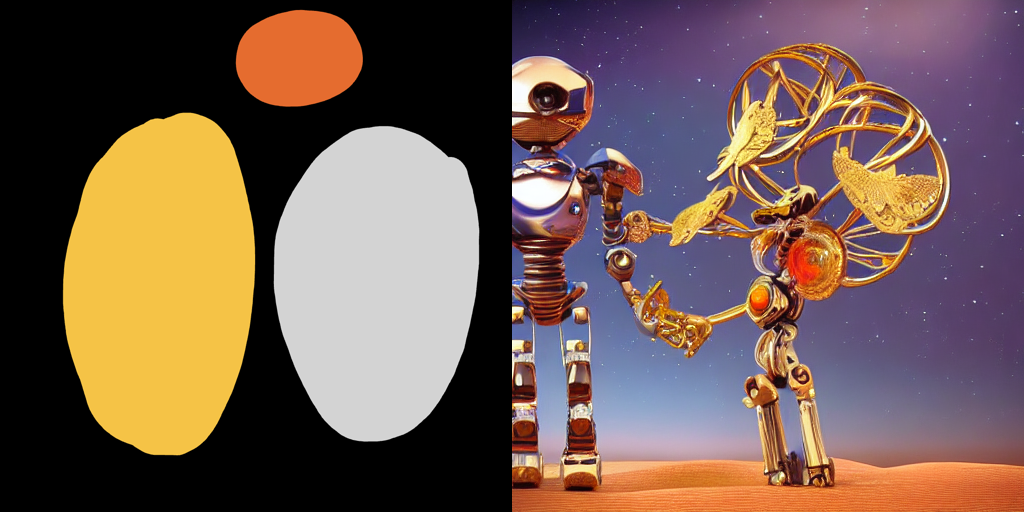

In [6]:
imgs_dict[3]

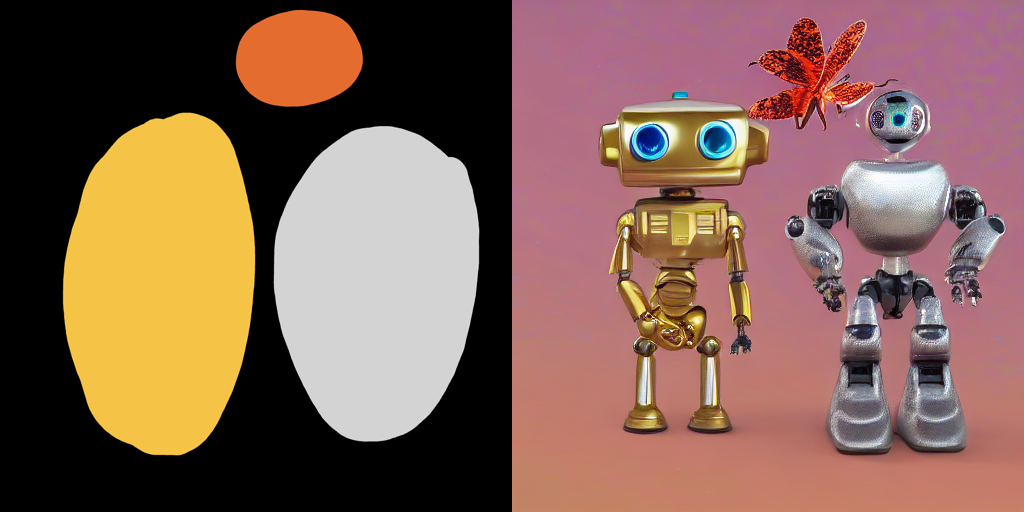

In [135]:
imgs_dict[3]

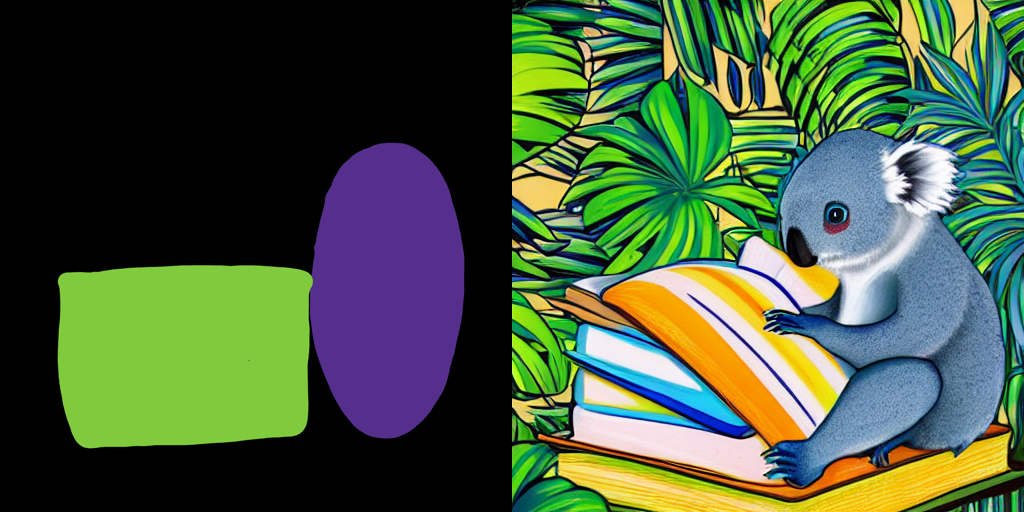

In [124]:
imgs_dict[2]

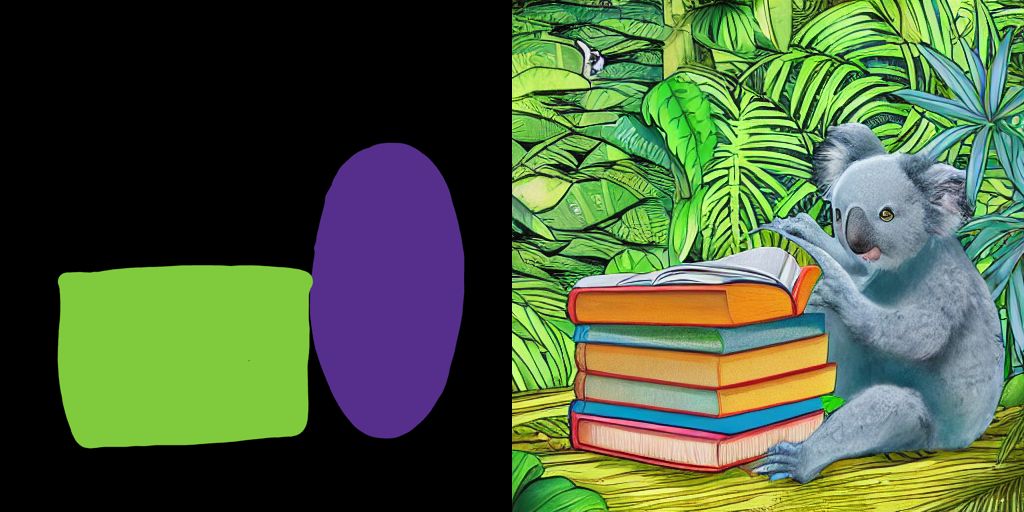

In [118]:
SD_wom

In [119]:
1/0

ZeroDivisionError: division by zero

In [55]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Storing attention in each timestep & visualization

In [43]:


import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import cv2
from typing import Optional, Union, Tuple, List, Callable, Dict
from IPython.display import display
from tqdm.notebook import tqdm
import diffusers
import matplotlib.pyplot as plt
import inspect

def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img


def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    # display(pil_img)
    return pil_img

In [12]:
attn1 = attentions_idx[1][0]

In [29]:
attn1.keys()

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])

In [33]:
prompts = ['A painting of a dog riding a flying bicycle, over a big city with a yellowish full moon in the night sky.']

In [41]:
tokens = pipe.tokenizer.encode(prompts[0])

In [97]:
def aggregate_attention(attention_store, res:int, from_where: List[str], is_cross: bool, select: int):
    out = []
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_store[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps) 
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    
    return out.cpu()

In [98]:
def show_cross_attention(attention_store, res:int, from_where: List[str], select: int = 0, num_rows=1):
    tokens = pipe.tokenizer.encode(prompts[select])
    decoder = pipe.tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
        
    return view_images(np.stack(images, axis=0), num_rows)

In [107]:
a=np.ones((2,2)).astype(float)

In [121]:
def show_self_attention_comp(attention_store, res:int, from_where: List[str], max_com=10, select: int = 0, num_rows=1):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2)).astype(float)
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)

    return view_images(np.concatenate(images, axis=1), 1)

In [119]:
def get_attention_timesteps(attention_store_timestep, res, from_where, select, num_rows):
    cross_attns = []
    self_attns = []
    print(select)
    for attention_store in attention_store_timestep:
        cross_attns.append(show_cross_attention(attention_store, res, from_where, select, num_rows))
        self_attns.append(show_self_attention_comp(attention_store, res, from_where, select=select, num_rows=num_rows))     
    
    return cross_attns, self_attns

In [120]:
cas, sas = get_attention_timesteps(attentions_idx[1], 24, ['down','up'], 0, 3)

0
(576, 576) (576,) (576, 576)
10 (256, 256, 3)
(576, 576) (576,) (576, 576)
10 (256, 256, 3)
(576, 576) (576,) (576, 576)
10 (256, 256, 3)
(576, 576) (576,) (576, 576)
10 (256, 256, 3)


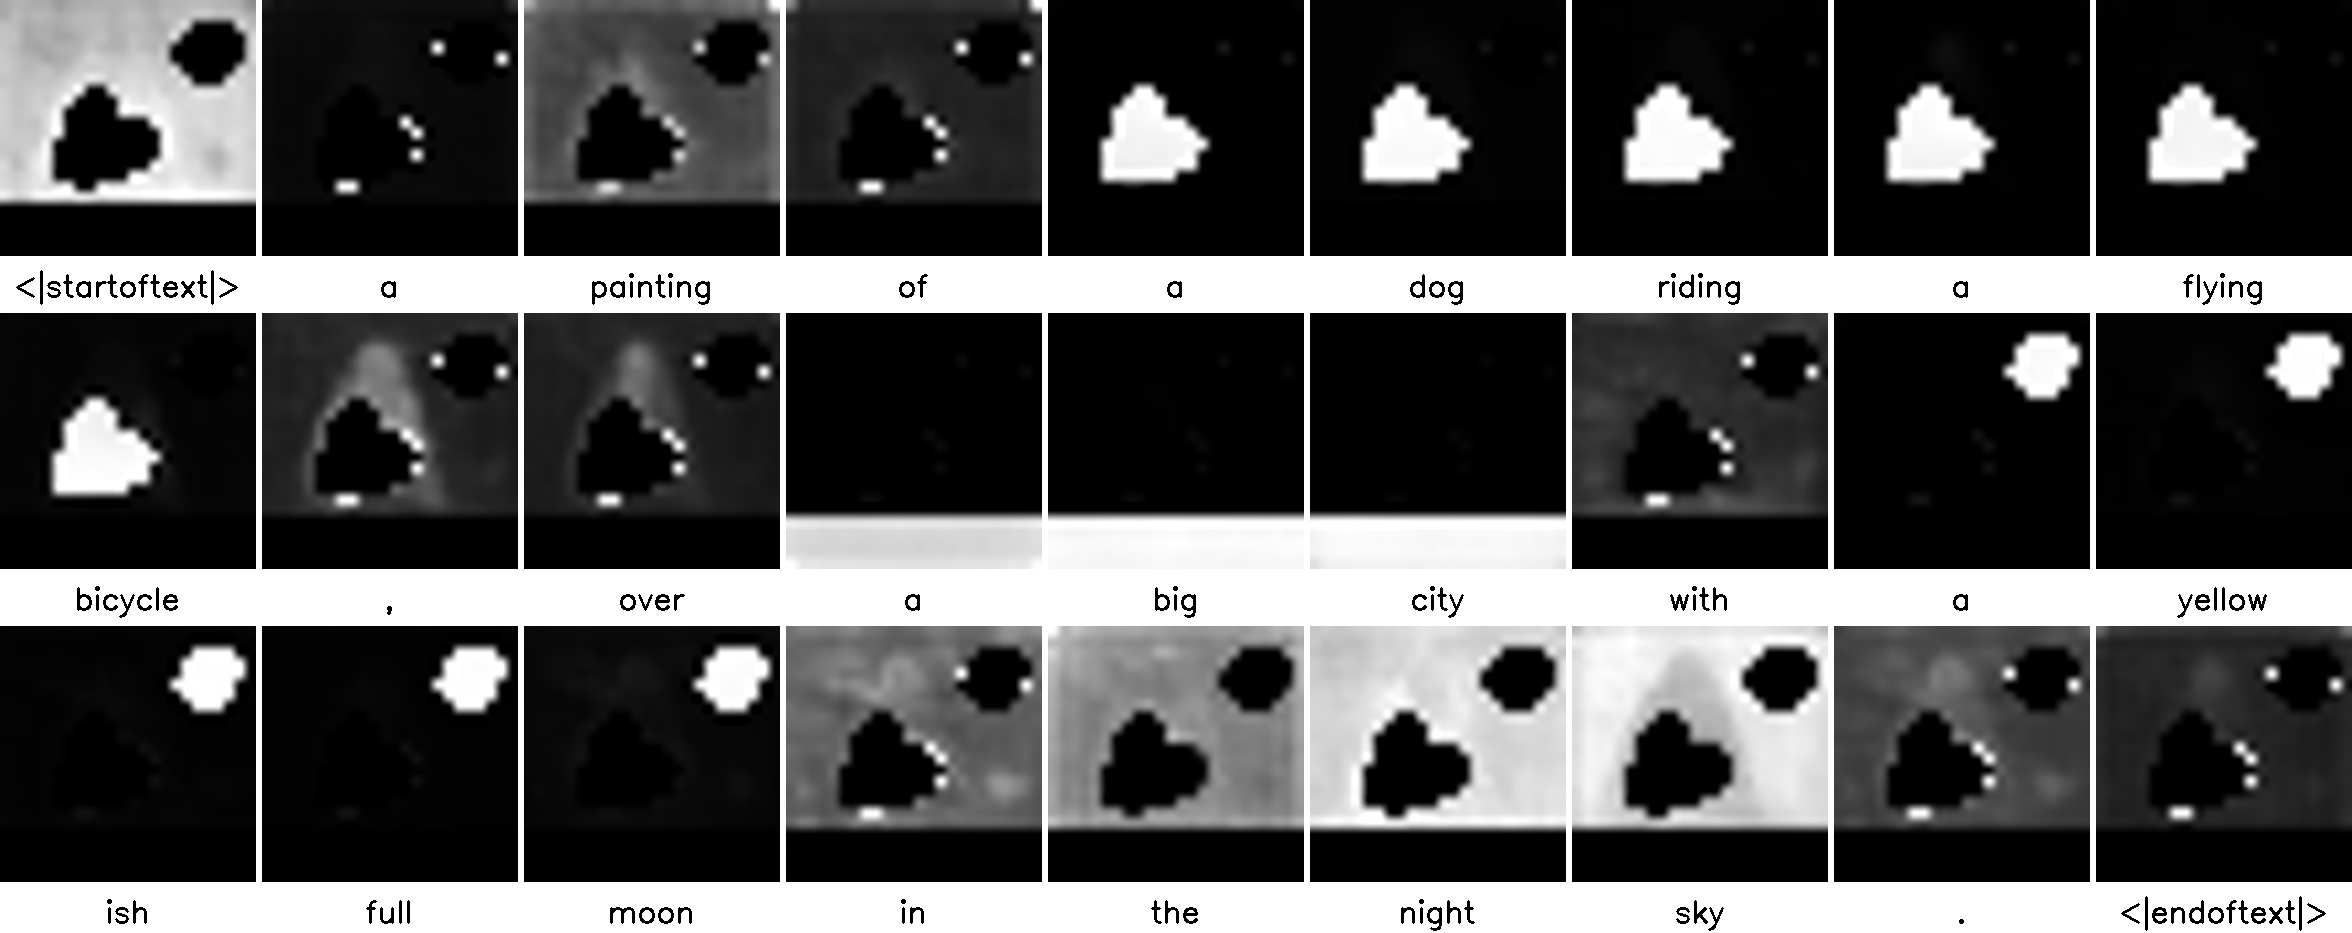

In [127]:
cas[0]

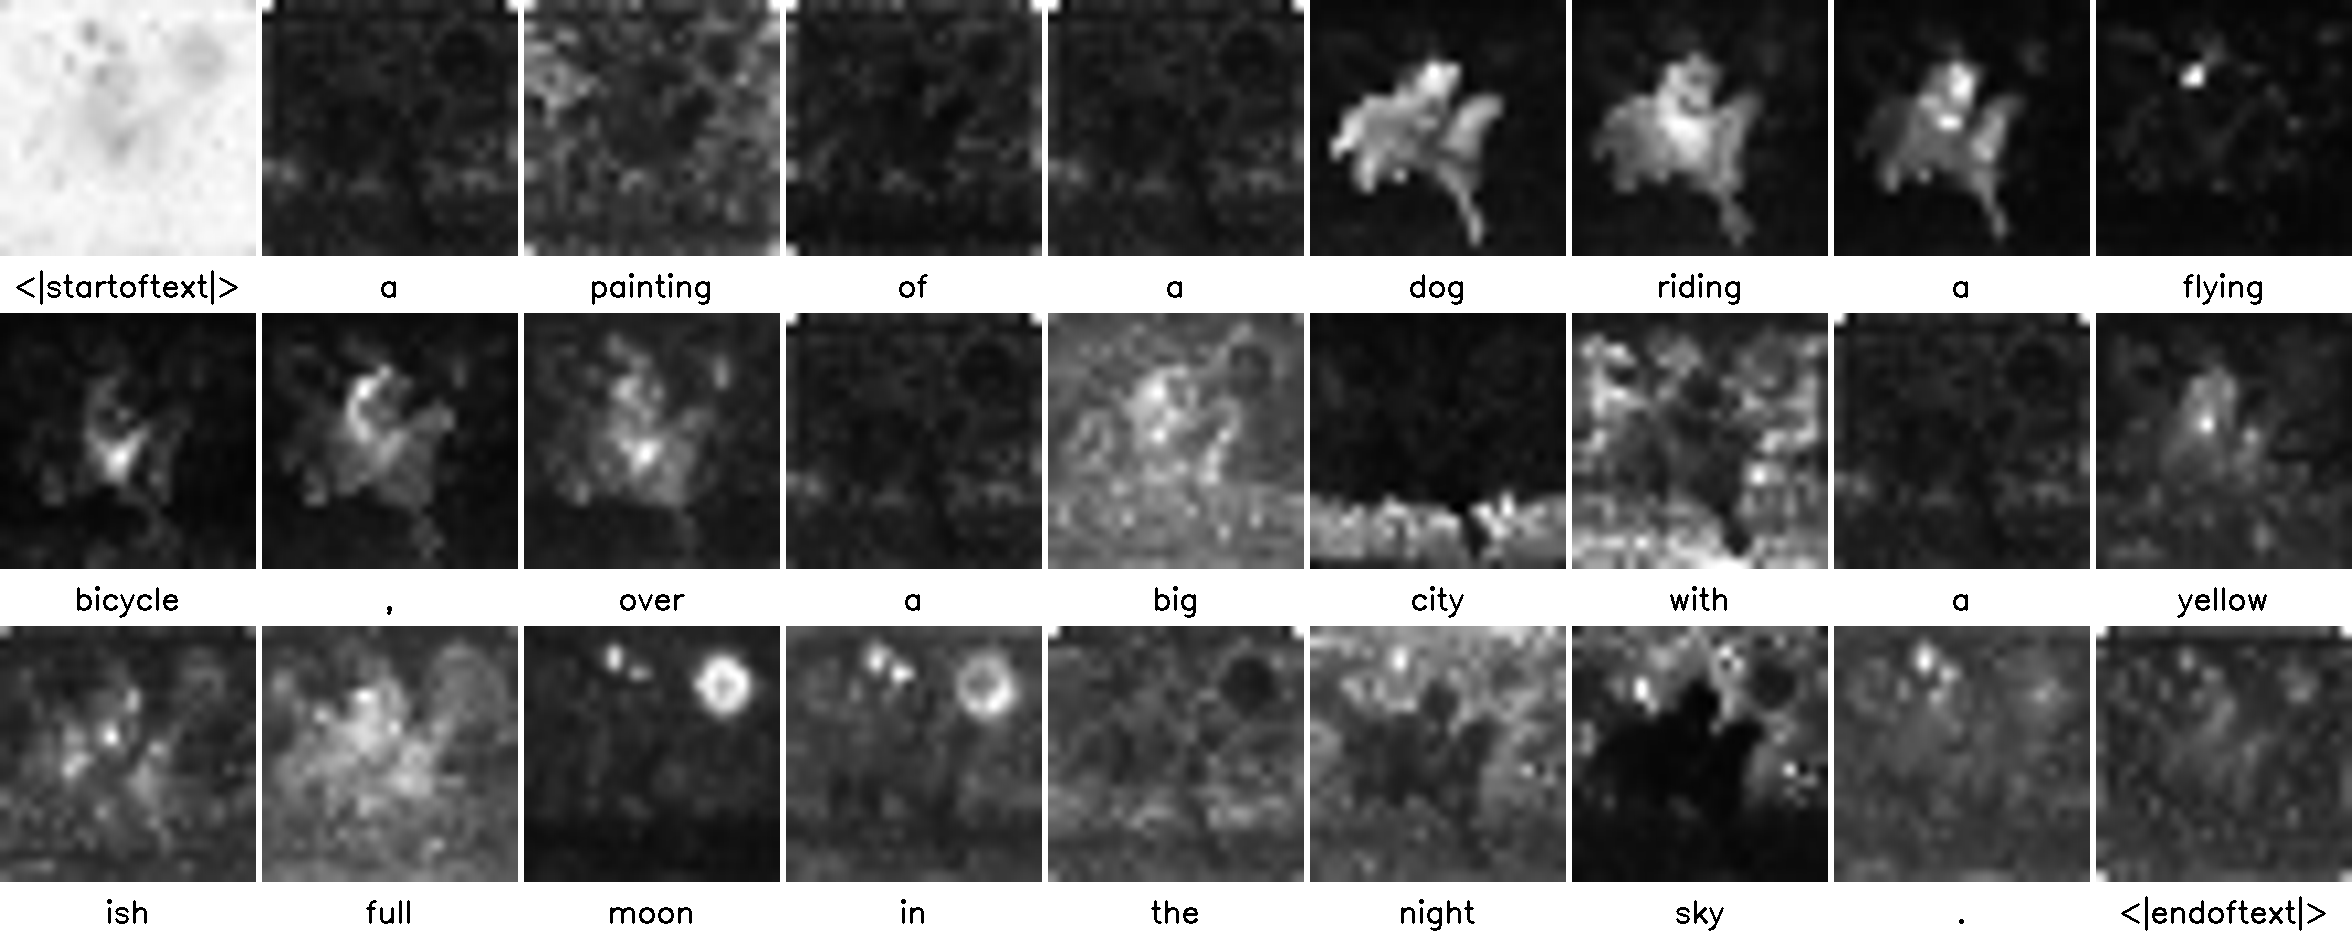

In [126]:
cas[3]

In [39]:
out = torch.cat(out, dim=0)
out = out.sum(0) / out.shape[0]

In [45]:
attention_maps = out.cpu()

In [48]:
np.stack(images, axis=0).shape

(27, 307, 256, 3)

In [49]:
attention_maps.shape

torch.Size([24, 24, 77])

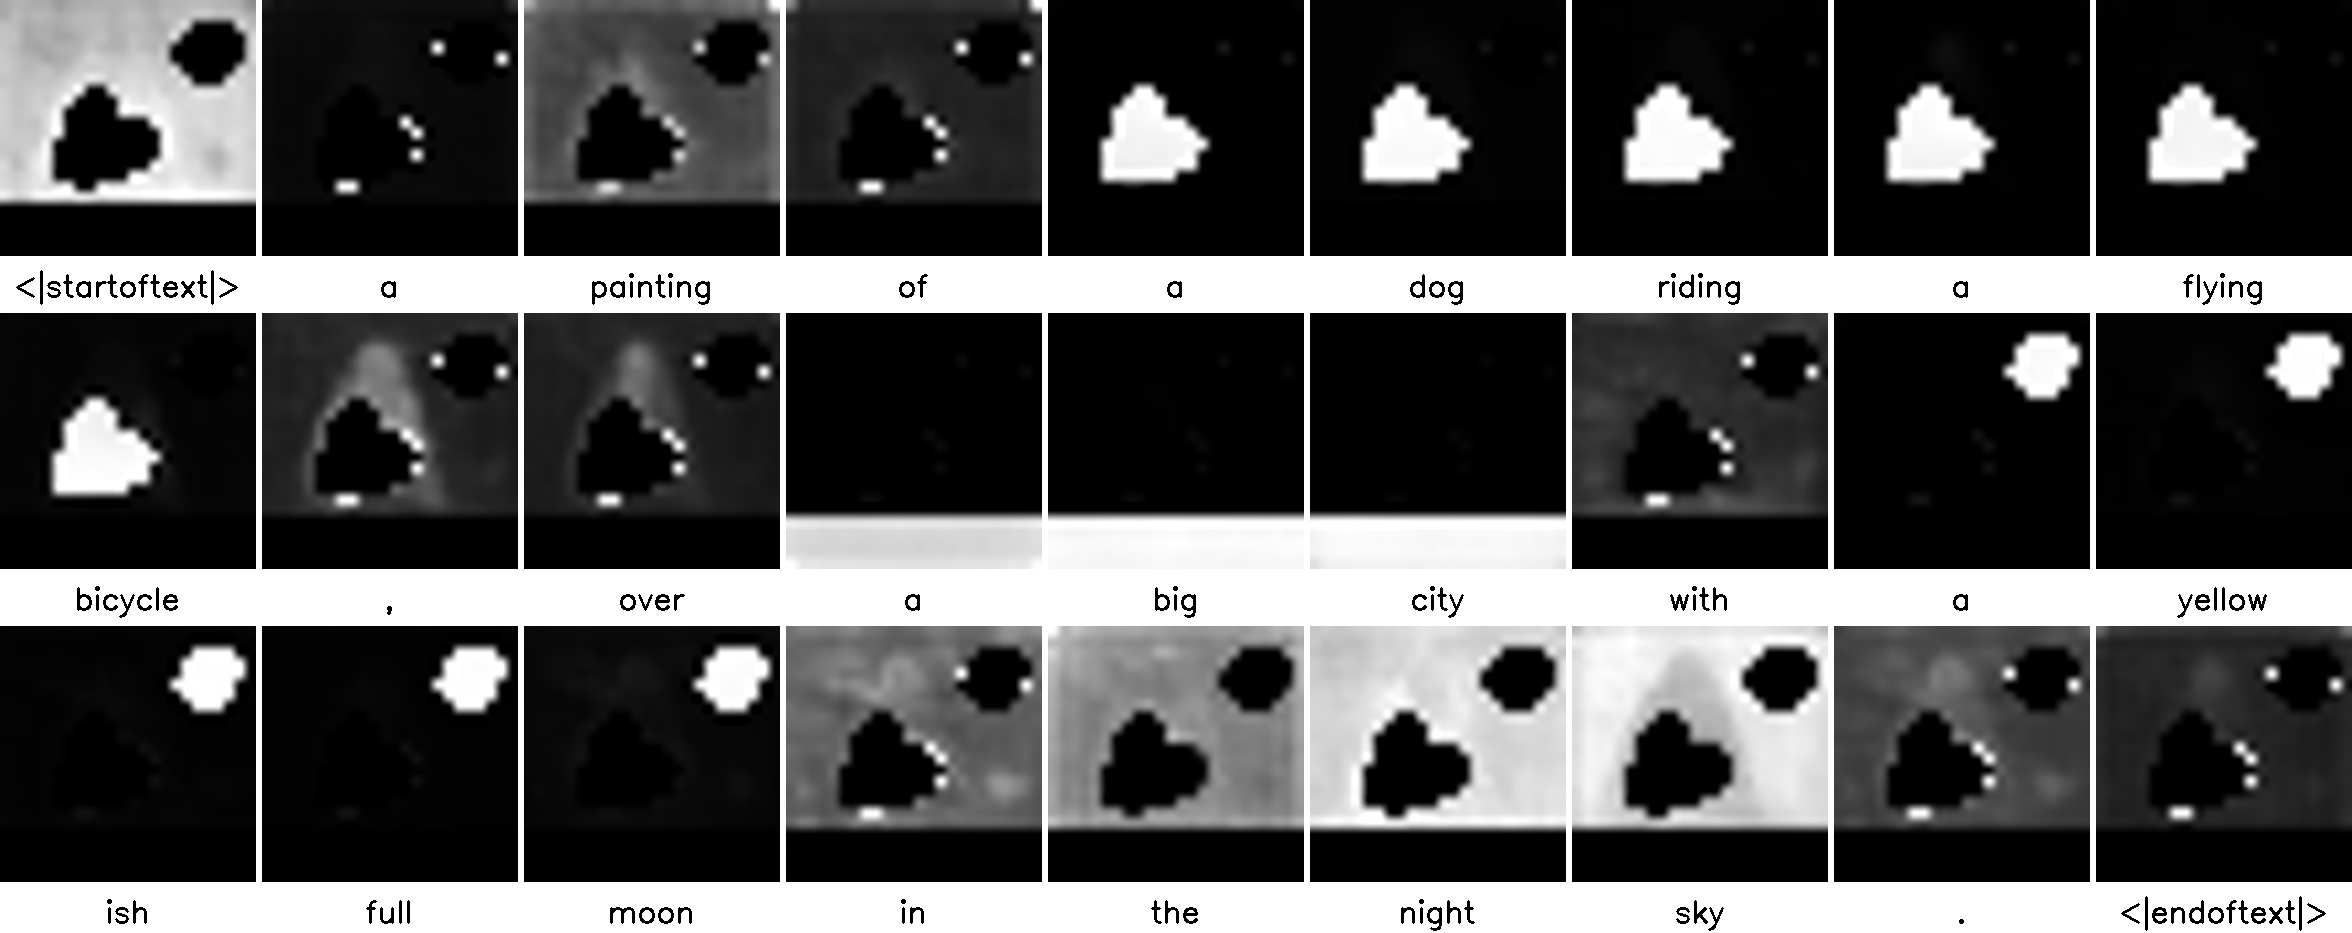

In [54]:
decoder = pipe.tokenizer.decode
images = []
for i in range(len(tokens)):
    image = attention_maps[:, :, i]
    image = 255 * image / image.max()
    image = image.unsqueeze(-1).expand(*image.shape, 3)
    image = image.numpy().astype(np.uint8)
    image = np.array(Image.fromarray(image).resize((256, 256)))
    image = text_under_image(image, decoder(int(tokens[i])))
    images.append(image)
view_images(np.stack(images, axis=0),3)

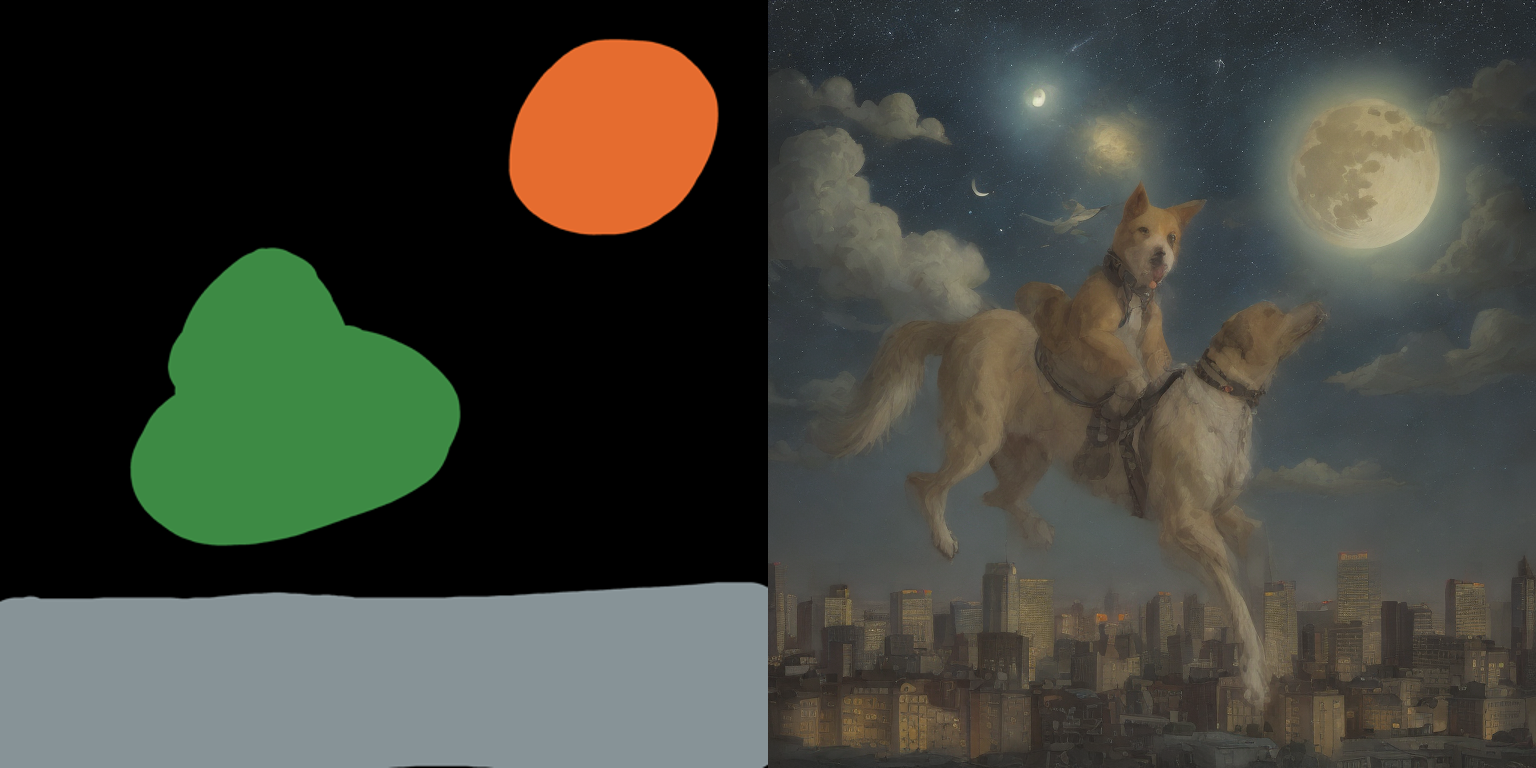

In [52]:
imgs_idx[1]

In [11]:
for m in pipe.unet.modules():
    n = m.__class__.__name__
    if 'Up' in n:
        print(n)

UpBlock2D
Upsample2D
CrossAttnUpBlock2D
Upsample2D
CrossAttnUpBlock2D
Upsample2D
CrossAttnUpBlock2D
